# Virtual scan workbook 

Explains the workflow for generating hyperspectra from inputs

### Imports

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

### Functions

In [6]:
def add_padding_to_images(input_array, new_size, padding_value=0):
    """
    Adds padding to every picture in the input array.
    ----------
    Parameters
    ----------
        input_array; ndarray 
            The input array of shape (n_images, height, width).
        
        new_size: int 
            The desired new width and height of the padded images.
        
        padding_value: int or float
            The value to use for padding. Default is 0.
        
    Returns:
        numpy.ndarray: The padded array of shape (n_images, new_size, new_size).
    """
    n_images, original_height, original_width = input_array.shape
    
    if new_size <= original_height or new_size <= original_width:
        raise ValueError("New size must be greater than the original dimensions.")
    
    # Calculate padding sizes
    padding_height = (new_size - original_height) // 2
    padding_width = (new_size - original_width) // 2
    
    # Create padded array
    padded_array = np.full((n_images, new_size, new_size), padding_value, dtype=input_array.dtype)

    # Copy original images into the center of the new array
    for i in range(n_images):
        padded_array[i,
                     padding_height:padding_height + original_height,
                     padding_width:padding_width + original_width] = input_array[i]
    
    return padded_array

def resample_imporved(images: np.ndarray, new_width: int) -> np.ndarray:
    """
    Takes a square image and resamples it to another square image of different 
    dimensions
    Principle behined it is finds the lowest common multiple of the new and old 
    dimensions, then scales it up using np.repeat to be the size of the lcm, 
    then takes an average over an intiger number of squares to downsample to 
    new dimensions

    improved time and efficiency of resample_image_by_scale() 
    ----------
    Parameters
    ----------
    image : np.ndarray
        Square (n,n) array that will be resampled
    new_width : int
        width of new resampled image

    -------
    Returns
    -------
    new_image : np.ndarray
        new resampled image dimesnsions (new_width, new_width)
        
    None if not a square
    """
    if images.shape[1] != images.shape[2]:
        print("Not a square image")
        return None
    
    total = len(images)
    n = images.shape[1]
    m = new_width

    if m == n:
        return images
    
    from math import lcm
    
    lcm_mn = int(lcm(n,m))
    
    multiply_scale = int(lcm_mn/n)
    reduction_scale = int(lcm_mn/m)
    
    new_images = np.repeat(np.repeat(images, multiply_scale, axis=1), multiply_scale, axis=2)
    if reduction_scale == 1:
        return new_images

    
    new_images = new_images.reshape(total, m*reduction_scale, m, reduction_scale).mean(axis=-1)
    rot_image = np.rot90(new_images, 1, (1,2))
    new_images = rot_image.reshape(total, m, m, reduction_scale).mean(axis=-1).reshape(total,m,m)
    un_rot_image = np.rot90(new_images, -1, (1,2))
    
    return un_rot_image

def multiplied(data, mult):
    """
    multiplys each value in any dimentional array by mult
    """
    mult_matrix = np.full(data.shape, mult)
    return data*mult_matrix
    # another method that when tested was marginaly slower
    # return np.array(data.flatten() * mult).reshape(data.shape)

def log_scale_data(data, undo=False):
    """
    transforms data values b:y y = log(x+1) 
    undo will do inverse transform: x = e^(y) - 1
    """
    if undo:
        transformed_data = np.array(np.e**data.flatten() - 1)
    else:
        transformed_data = np.array(np.log(data.flatten() + 1)).reshape(data.shape)
    return transformed_data.reshape(data.shape)

def norm(data, reduction_factor=None):
    """
    normalises data based on either a predefined factor or the highest value in the data
    """
    if not reduction_factor:
        flat_data = data.flatten()
        reduction_factor = max(flat_data)
        return (flat_data/reduction_factor).reshape(data.shape), reduction_factor
    else:
        flat_data = data.flatten()
        return (flat_data/reduction_factor).reshape(data.shape)
    

### Virtual scan function

In [101]:
def take_virtual_scan(data, mult, power, rot, model_path=None, padding_value=0, invert=False, model=None):
    """
    This script takes in data like in the physical system, but loads a keras model and does the prediction    
    ----------
    Parameters
    ----------
    data: ndarray
        This is the raw image data that is to be fed into the system images stacked on axis=0 and must be square.
        
    mult: int 
        Same as in take_scan() from experiment
            Images have a multiplication factor that scales up the images to fit within a total boarder of 532
            This code finds the length for experiment then scales it for the model
            
    power: int
        power of the laser in the experiment.
    
    rot: int
        same as experimental procedure, rotates images 90 degrees using np.rot90
        
    model_path: str
        Path directory to where the model is stored.
        
    padding_value : int, optional
        If images do not fill the full space, padding is added usualy the modal pixel strength in the data. 
        The default is 0.
        
    invert: bool, optional
        If the pixel data is to be inverted. 
        The default is False.
    
    model: keras.model
        used to make prediction if passed in, otherwise
        
    Returns
    -------
    ndarray
        predicted spectra from experiment.
    """
    if model == None and model_path == None:
        raise Exception("There has been no model or path has been passed in")
        
    def ssim_loss(y_true, y_pred):
        return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

    tf.keras.utils.get_custom_objects().update({'ssim_loss': ssim_loss})
    
    if len(data.shape) != 3:
        shape = data.shape
        data = data.reshape(shape[0], shape[1], shape[2])
    data = np.rot90(data, -1+rot, axes=(1, 2))
    scan_pic_width = data.shape[1]*mult # how the experimental set up uses mult
    new_size = int(scan_pic_width/4) # the twin uses a width and height that is 4x smaller than the expeimental set up
    
    print("Resizing images")
    x = resample_imporved(data, new_size) # rescales the data to be correct dimensions

    
    if new_size != 133:
        x = add_padding_to_images(x, 133, padding_value) # adds padding if needed
    
    x = multiplied(x, power)
    x = add_padding_to_images(x, 138, 0) #  This is because I had origonaly made the model using the wrong as I was given the wrong info about the dimensions of the experimental setup...
    
    x = log_scale_data(x).reshape(*x.shape, 1)
    print("Inputs prepared")
    
    
    norm_factor = 11.5327379
    
    if model_path is not None: # if a model_path is passed in
        print("Model loading...")
        model = load_model(model_path)
        
    # predict and undo transforms
    print("Making predictions...")
    y_pred = model.predict(x)
    y_pred = np.array(y_pred, dtype=np.float32)
    y_pred = log_scale_data((y_pred.flatten()*norm_factor).reshape(y_pred.shape), undo=True)
    print("[Fin]")
    return y_pred

## Example usage

for this to run on your PC, you will need to replace the imports with however you import your data

Data overview: 11720 images: dimensions (28, 28)



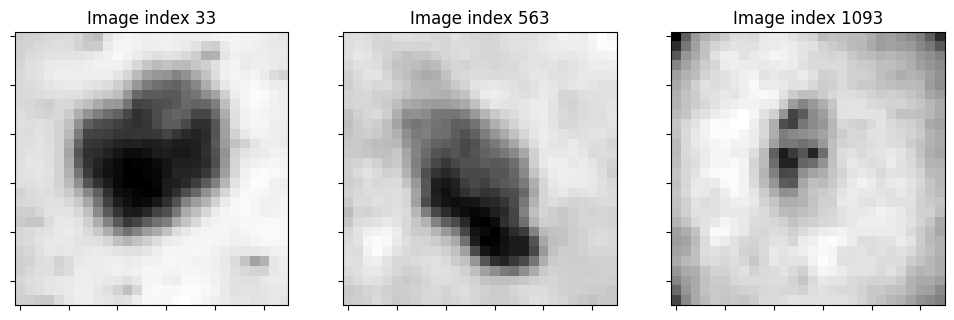

In [115]:
try:
    import datasets as ds
except:
    raise Exception("This uses Jakubs datasets.py module to get the data, please have it in this files directory")
    
data_path = "twin_data/source_images/ham28_shuffled.ds"
model_path = "big_train/100kdata/model_3_bs8_ep500_mse-ep30.keras"
data = ds.load(data_path).raw

print(f"Data overview: {data.shape[0]} images: dimensions {data.shape[1:]}\n")

# view some of the data
fig, axs = plt.subplots(1,3, figsize=[12,6])
for i, ax in enumerate(axs):
    index = i*530 +33
    ax.imshow(data[index],cmap="gray")
    ax.set_title(f"Image index {index}")
    ax.xaxis.set_ticklabels([]) ; ax.yaxis.set_ticklabels([])

# Values from experimental procedure
mult = 13 
pad_level = 166
power = 400
rot = 1
invert = False # not implemented yet

In [116]:
predictions = take_virtual_scan(data, mult, power, rot, model_path=model_path, padding_value=pad_level)

Resizing images
Inputs prepared
Model loading...
Making predictions...
367/367 [==============================] - 4s 10ms/step
[Fin]


Plotting some predictions

In [109]:
experimental_path = "twin_data/data/ham28_shuffled_gTrue_rot0_/DATA_20241101_Toriel120+_VoNetW350L05D150_ham28_shuffled_gTrue_rot0_0001.ds"
expr_spectra = ds.load(experimental_path).raw
expr_spectra = expr_spectra[:,10:74,65:193].reshape(len(expr_spectra),64,64,2).mean(axis=-1).reshape(len(expr_spectra),64,64)

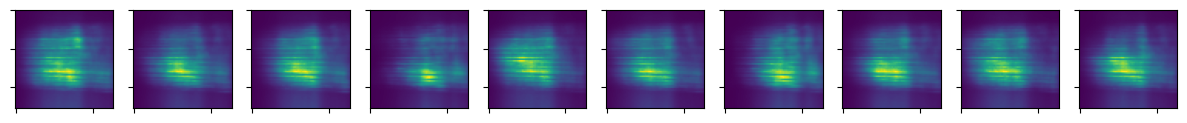

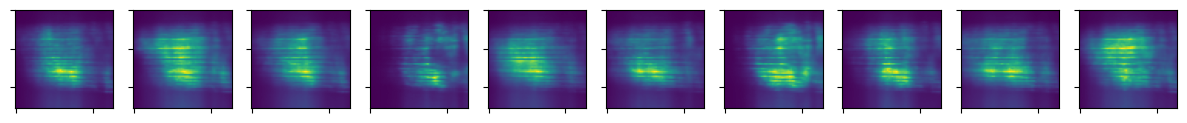

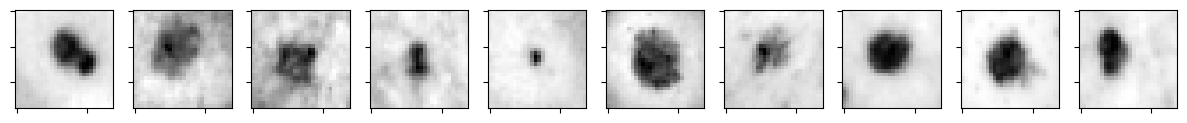

In [119]:
# predictions
fig, axs = plt.subplots(1,10, figsize=[15,6])
for i, ax in enumerate(axs):
    index = i*6 + 20
    ax.imshow(predictions[index])#,cmap="gray")
    #ax.set_title(f"Image index {index}")
    ax.xaxis.set_ticklabels([]) ; ax.yaxis.set_ticklabels([])
plt.show()
# experimental
fig, axs = plt.subplots(1,10, figsize=[15,6])
for i, ax in enumerate(axs):
    index = i*6 + 20
    ax.imshow(expr_spectra[index])#,cmap="gray")
    #ax.set_title(f"Image index {index}")
    ax.xaxis.set_ticklabels([]) ; ax.yaxis.set_ticklabels([])
    #print(max(data[index].flatten()),min(data[index].flatten()))
plt.show()
# images
fig, axs = plt.subplots(1,10, figsize=[15,6])
for i, ax in enumerate(axs):
    index = i*6 + 20 
    ax.imshow(data[index],cmap="gray")
    #ax.set_title(f"Image index {index}")
    ax.xaxis.set_ticklabels([]) ; ax.yaxis.set_ticklabels([])
    #print(max(data[index].flatten()),min(data[index].flatten()))
plt.show()

It doesn't get it perfect but it does alright. One thing I've noticed in the generated hyperspectra is it really favours this single mode that's always very active. This is also data not from the test set but completley new data so don't expect it to be perfect, but is also a nice test to see how it reacts to new types of data

## More functions breaking the sections into seperate tasks

The reason you would want this is for using for other tasks like mask training, you wouldn't want to load the model each time

In [123]:
def pre_process_images(data, mult, rot, power, padding_value):
    """
    takes in images and pre-processing variables and returns images that the model can make direct predictions on 
    """
    if len(data.shape) != 3:
        shape = data.shape
        data = data.reshape(shape[0], shape[1], shape[2])
    data = np.rot90(data, -1+rot, axes=(1, 2))
    scan_pic_width = data.shape[1]*mult # how the experimental set up uses mult
    new_size = int(scan_pic_width/4) # the twin uses a width and height that is 4x smaller than the expeimental set up
    
    print("Resizing images")
    x = resample_imporved(data, new_size) # rescales the data to be correct dimensions

    
    if new_size != 133:
        x = add_padding_to_images(x, 133, padding_value) # adds padding if needed
    
    x = multiplied(x, power)
    x = add_padding_to_images(x, 138, 0) #  This is because I had origonaly made the model using the wrong as I was given the wrong info about the dimensions of the experimental setup...
    
    x = log_scale_data(x).reshape(*x.shape, 1)
    print("Inputs prepared")
    return x

def load_model_with_path(model_path):
    """
    given the model path, this imports the custom accuracy function so you can load the model
    """
    # custom accuracy function that you need to load the model
    def ssim_loss(y_true, y_pred):
        return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

    tf.keras.utils.get_custom_objects().update({'ssim_loss': ssim_loss})
    
    return load_model(model_path)

def predict(pre_processed_images, model):
    """
    takes pre_processed_images and the loaded model and creates predictions
    """
    return model.predict(pre_processed_images)

def post_process_spectra(spectra):
    """
    takes generated spectra and returns back to normal experimental data
    """
    norm_factor = 11.5327379 # hyper-param of the training
    spectra = np.array(spectra, dtype=np.float32)
    spectra = log_scale_data((spectra.flatten()*norm_factor).reshape(spectra.shape), undo=True)
    return spectra

def expr_process_to_compare(expr_spectra):
    """
    experimental spectra has more data as training was on cropped data, this is the function that was used to get the trained spectra
    """
    return expr_spectra[:,10:74,65:193].reshape(len(expr_spectra),64,64,2).mean(axis=-1).reshape(len(expr_spectra),64,64)
    

## Example Workflow

load images -> pre-process images -> load model -> make prediction -> process the spectra data -> process experimental data -> compare

in other tasks example workflow may be:

load images -> pre-process images -> load model -> training loop:
     - add mask
     - make prediction (pass through model)
     - calculate loss for mask training
     - update mask
     - repeat
     
loading the model and processing the data seperatly will drastically decrease the time taken for training

In [ ]:
path = "put/your/data/path/here.ty"
images = ds.load(path).raw
mult = 13; rot = 0; power = 400; pad_val = 166
processed_images = pre_process_images(images, mult, rot, power, padding_value)
model = load_model_with_path("model/path/goes/here.ty")
predictions = predict(processed_images, model)
pred_spectra = post_process_spectra(predictions)

expr_spectra = ds.load("expr/spectra/path/here.ty")
comparison_expr_spectra = expr_process_to_compare(expr_spectra)

# pred_spectra vs comparison_expr_spectra plotted

actual implementation with ham data from above

In [125]:
images = ds.load("twin_data/source_images/ham28_shuffled.ds").raw
mult = 13; rot = 0; power = 400; pad_val = 166
processed_images = pre_process_images(images, mult, rot, power, pad_val)
model = load_model_with_path("big_train/100kdata/model_3_bs8_ep500_mse-ep30.keras")
predictions = predict(processed_images, model)
pred_spectra = post_process_spectra(predictions)

expr_spectra = ds.load("twin_data/data/ham28_shuffled_gTrue_rot0_/DATA_20241101_Toriel120+_VoNetW350L05D150_ham28_shuffled_gTrue_rot0_0001.ds").raw
comparison_expr_spectra = expr_process_to_compare(expr_spectra)

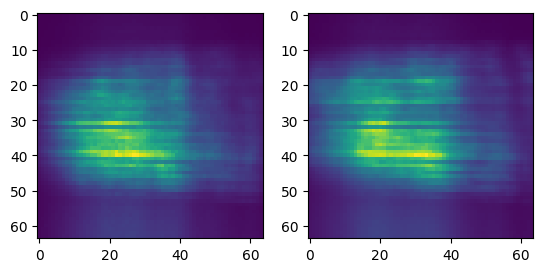

In [127]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(pred_spectra[2])
ax[1].imshow(comparison_expr_spectra[2])